#Computer Vision Lab Assignment [2]
######Sally Reda - 120210008
######Nada Gomaa - 120210358



---



# Image

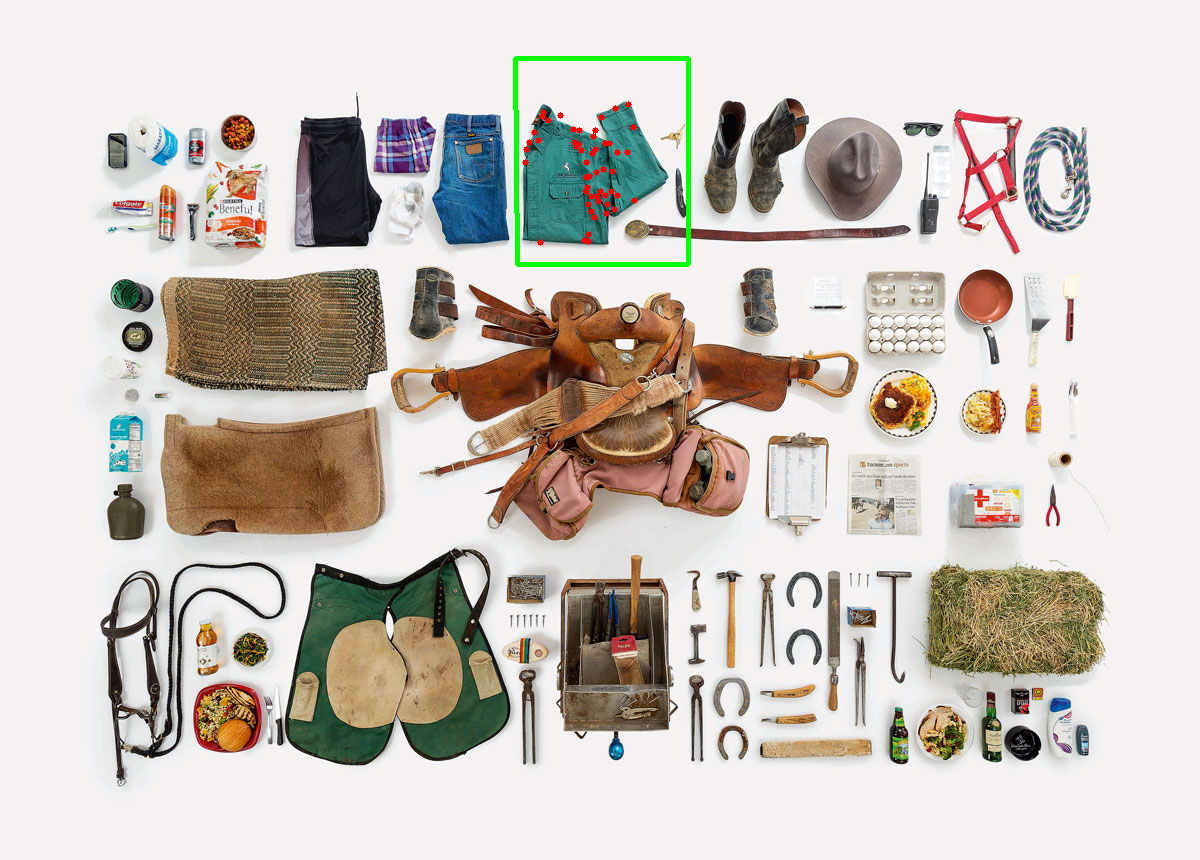

In [25]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load images in COLOR
query_color = cv2.imread('query.jpg')
target_color = cv2.imread('target.jpg')

# Convert to GRAYSCALE for processing
query_gray = cv2.cvtColor(query_color, cv2.COLOR_BGR2GRAY)
target_gray = cv2.cvtColor(target_color, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors using GRAYSCALE images
kp_query, des_query = sift.detectAndCompute(query_gray, None)
kp_target, des_target = sift.detectAndCompute(target_gray, None)

# FLANN matcher setup
FLANN_INDEX_KDTREE = 1
index_params = {'algorithm': FLANN_INDEX_KDTREE, 'trees': 5}
search_params = {'checks': 50}
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Feature matching with ratio test
matches = flann.knnMatch(des_query, des_target, k=2)
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

MIN_MATCHES = 10
if len(good_matches) > MIN_MATCHES:
    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp_target[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Compute homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if M is not None:
        h, w = query_gray.shape
        query_corners = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
        target_corners = cv2.perspectiveTransform(query_corners, M)
        target_corners = np.int32(target_corners)

        # Draw directly on COLOR target image
        cv2.polylines(target_color, [target_corners], True, (0,255,0), 3)

        # Draw matching points (red) on color image
        for i, (pt, inlier) in enumerate(zip(dst_pts, mask.ravel().tolist())):
            if inlier:
                x, y = pt.ravel()
                cv2.circle(target_color, (int(x), int(y)), 3, (0,0,255), -1)

        # Save and show results
        cv2.imwrite('detected_object_color.jpg', target_color)
        cv2_imshow(target_color)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Homography computation failed")
else:
    print(f"Insufficient matches: {len(good_matches)}/{MIN_MATCHES}")



---



# Video

In [ ]:
import cv2
import numpy as np

def video_object_detection(query_path, video_path, output_path="output_detected.mp4"):

    # Load the query image
    query_image = cv2.imread(query_path, cv2.IMREAD_GRAYSCALE)
    if query_image is None:
        print("Error: Could not load the query image.")
        return

    # Initialize SIFT detector and compute descriptors
    sift = cv2.SIFT_create()
    kp_query, des_query = sift.detectAndCompute(query_image, None)

    # FLANN Matcher for SIFT
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open the video.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        kp_frame, des_frame = sift.detectAndCompute(gray_frame, None)

        if des_frame is not None and des_query is not None:
            matches = matcher.knnMatch(des_query, des_frame, k=2)
            # Ratio test
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

            if len(good_matches) > 8:
                src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                # Homography for spatial consistency
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                matches_mask = mask.ravel().tolist() if mask is not None else []

                inliers = sum(matches_mask) if mask is not None else 0
                if M is not None and inliers > 6:
                    h, w = query_image.shape
                    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                    dst = cv2.perspectiveTransform(pts, M)
                    frame = cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 0), 3)
                    cv2.putText(frame, f"Inliers: {inliers}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                else:
                    cv2.putText(frame, f"No detection", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            else:
                cv2.putText(frame, f"Low matches: {len(good_matches)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        else:
            cv2.putText(frame, "No features found", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Output video saved as {output_path}")

# Example usage:
query_image_path = "/content/queryAA.jpg"  # Replace with your query image path in Colab
video_path = "/content/video.mp4"         # Replace with your video path in Colab
output_video_path = "/content/output_detected.mp4"
video_object_detection(query_image_path, video_path, output_video_path)